In [1]:
import os
import time
import logging
import numpy as np
from scipy.sparse.linalg import svds
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from prettytable import PrettyTable


# Robust Principal Component Analysis






L'objectif est de separer une matrice  en une matrice de rang minimal dont on ne connais pas la valeur et un bruit sparse dont o ne connait pasle nombre de valeurs non null ni lur position. Ils sont obtenus en résolvant un problème convexe qui minimise une combinaison pondérée de la norme nucléaire et de la norme $L_1$. Le probléme à resoudre est le suivant:

\begin{equation}
\begin{split}
minimize \quad \|L\|_* + \lambda \|S\|_1 \\
subject\quad to \quad S + L = M
\end{split}
\end{equation}

Ce problème est connu sous le nom de **Principal Components Poursuit(PCP)**. Pour le résoudre,
l'article suggère d’utiliser le **Multiplicateur du Lagrangien Augmenté (ALM)**  pour résoudre le PCP: 
$$ l(L,S,Y)=\|L\|_* + \lambda \|S\|_1 + (Y,M-L-S)  + \frac{\mu}{2}  \|M-L-S\|_F^2 $$
Le principe de cet algorithme est simple et calcule de manière itérative $(L_k,S_k)= argmin_{L,S}(L,s,Y_{k})$ et $Y_{k+1}= Y_{k} + \mu(M-L_{k+1}-S_{k+1})$. De plus, il est plus simple et plus efficace de chercher $ argmin_{L}(L,s,Y)$  et  $argmin_{S}(L,s,Y) $ avec :

$$ argmin_{L}(L,s,Y)= S_{ \lambda \mu ^{-1}}(M-L + \mu^{-1}Y)$$ où $S_\rho (x)=sgn(x)mac(|x|-\rho,0)$
 et $$ argmin_{S}(L,s,Y)= D_{ \mu ^{-1}}(M-S_k + \mu^{-1}Y)$$ où $D_\rho (X)=US_\rho (\Sigma)V^*$ et $U\Sigma V^*$. 



On prendra :

**-**   $ \mu=\frac{n_1 n_2}{4\|M\|_1}$ ,

**-** un critère d’arrêt :$\|M-L-S\|_F< \delta \|M\|_F$ avec $\delta=10^{-7}$

**-** et $\lambda=\frac{1}{\sqrt[]{max(n_1,n_2)}}$.


**L'algorithm ALM se presente comme suit:**
 
> **Initialisation**: $S_0=Y_0, \mu >0$. 

>**Tant que**  cela ne converge pas  **faire**:

>> **calculer** $L_{k+1}=D_{ \mu ^{-1}}(M-S_k + \mu^{-1}Y_K)$

>> **calculer** $S_{k+1}=S_{ \lambda \mu ^{-1}}(M-L_{k+1} + \mu^{-1}Y_k)$

>> **calculer** $Y_{k+1}= Y_{k} + \mu(M-L_{k+1}-S_{k+1})$

>**fin** Tant que

>**Sortie**: L, S
 

# 1-Multiplicateur du Lagrangien Augmenté (ALM)
Dans ce qui suit, nous allons mettre en pratique le pseudo algorithm ci-dessus: 

In [2]:
def pcp(M, maxiter=500, delta=1e-6):
   
    shape = M.shape
   
    # Initialisation des parametres à optimiser
    lamda = 1.0 / np.sqrt(np.max(shape))
    mu = 0.25 * np.prod(shape) / np.sum(np.abs(M))
    
  
    # Etape 0 :.Initialisation: S_0=Y_0=0
    i = 0
    S = np.zeros(shape)
    Y = np.zeros(shape)
    debut_pcp = time.time()
    
    while i < max(maxiter, 1):
        # SVD 
        strt = time.time()#debut svd
        u, s, v = np.linalg.svd(M - S + Y / mu,full_matrices= False)
        
        svd_time = time.time() - strt#fin svd
        
        s = shrink_operator(s, 1./mu)
        L = np.dot(u, np.dot(np.diag(s), v))
        S = shrink_operator(M - L + Y / mu, lamda / mu)

        # Mis à jour de Y
        Y += mu *(M - L - S)

        # Calcul de l'errer
        err = np.linalg.norm(M - L - S, 'fro') / np.linalg.norm(M)
        #Affichage de l'etage d'itération , ainsi que l'erreur , le rang et le sparse error
        print(("Iteration {0}: error={1:.3e}, rank(L)={2:d}, Norme(S)={3:d}, "
                   "time={4:.3e}")
                  .format(i, err,np.linalg.matrix_rank(L), np.sum(abs(S)>0.00001 ), svd_time))
        #Verification de la convergence
        if err < delta:
            break
        i += 1
        
        rang_L=np.linalg.matrix_rank(L)
        norme_S=np.sum(abs(S)>0.00001 )
    pcp_time = time.time() - debut_pcp
    
    return L, S, (u, s, v),rang_L,norme_S,pcp_time

#Definition de la fonction shrink operator
def shrink_operator(M, tau):
    sgn = np.sign(M)
    S = np.abs(M) - tau
    S[S < 0.0] = 0.0
    return sgn * S



# 2-Similation de données

Le scenario de simultion est le suivant:
> **-** On considère une matrice de taille n et on le fait varier  (n=500,1000,2000),

> **-** on choix le paramètre$ r= rang(L_0) =  0.05 \times n$ et  $k=\|S_0\|= 0.05 \times n^2$,

> **-** $L_0=XY^*$  avec X et Y généré suivant $N(0,\frac{1}{n})$ de taille n x r,

> **-** et $S_0$ est généré en utilisant $P_\Omega$: $S_0=P_\Omega E$ avec E une matrice où les entrées sont des Bernoulli.

on a :$$
P_\Omega : \left\{
\begin{array}{ccc}
R^{u\times v} & \to & R^{u\times v}\\
A & \to & P_\Omega(A)
\end{array}
\right. \mbox{ where } (P_\Omega(A))_{ij} = \left\{
\begin{array}{cc}
A_{ij} & \mbox{ if } (i,j)\in\Omega\\
0 & \mbox{ otherwise}
\end{array}
\right.
$$

In [3]:
#Définition du masque P_omega
def mask(n1, n2, proportion = 0.2):
    mat_mask = np.random.binomial(1, proportion, size =  (n1, n2))
    #print("We observe {} per cent of the entries of a {}*{} matrix".format(100 * mat_mask.mean(),n1, n2))
    return mat_mask

In [4]:
N=[500,1000,2000]
#Initialisation des lists 
rang_l0=[]
sparse_s0=[]
list_rang=[]
list_sparse=[]
montime=[]

for n in N:
    print(n)
#définition des parametres 
    r=int(0.05*n)
    k=int(0.05*n**2)
    rang_l0.append(r)
    sparse_s0.append(k)
#calcule de L0
    mean = np.zeros(r)  
    covariance =  (np.eye(r))/n
    
    x = np.random.multivariate_normal(mean, covariance/n,n)#simulation de X 
    y = np.transpose(np.random.multivariate_normal(mean, covariance/n,n))#simulation  de Y
    
    L0=np.dot(x,y)
#calcule de S0   
    n1=n2=n
    E = np.random.binomial(1, 0.5, size =  (n1, n2))
    E[E<1]=-1
    mast_omage = mask(n1, n2, 0.05)
    S0 =np.multiply(mast_omage, E)
#calcule de M0
    M0=L0+S0
#Application de PCP 
    L, S, (u, s, v),rang_L,norme_S,pcp_time = pcp(M0, maxiter=10000, delta=1e-6)
    list_rang.append(rang_L)
    list_sparse.append(norme_S)
    montime.append(pcp_time)
  

500
Iteration 0: error=2.099e-02, rank(L)=487, Norme(S)=24496, time=1.184e-01
Iteration 1: error=1.665e-03, rank(L)=493, Norme(S)=26040, time=1.011e-01
Iteration 2: error=7.299e-04, rank(L)=494, Norme(S)=26598, time=9.745e-02
Iteration 3: error=4.247e-04, rank(L)=495, Norme(S)=26888, time=1.019e-01
Iteration 4: error=4.366e-04, rank(L)=493, Norme(S)=27132, time=9.167e-02
Iteration 5: error=6.281e-04, rank(L)=491, Norme(S)=27360, time=9.725e-02
Iteration 6: error=8.591e-04, rank(L)=490, Norme(S)=27608, time=9.622e-02
Iteration 7: error=1.039e-03, rank(L)=488, Norme(S)=27924, time=9.614e-02
Iteration 8: error=1.141e-03, rank(L)=486, Norme(S)=28287, time=1.203e-01
Iteration 9: error=1.172e-03, rank(L)=486, Norme(S)=28612, time=9.991e-02
Iteration 10: error=1.149e-03, rank(L)=484, Norme(S)=28921, time=9.539e-02
Iteration 11: error=1.109e-03, rank(L)=482, Norme(S)=29203, time=9.825e-02
Iteration 12: error=1.090e-03, rank(L)=479, Norme(S)=29470, time=9.582e-02
Iteration 13: error=1.101e-03, 

Iteration 112: error=6.992e-05, rank(L)=16, Norme(S)=21524, time=1.003e-01
Iteration 113: error=6.948e-05, rank(L)=16, Norme(S)=21504, time=1.146e-01
Iteration 114: error=6.904e-05, rank(L)=16, Norme(S)=21501, time=9.670e-02
Iteration 115: error=6.827e-05, rank(L)=17, Norme(S)=21361, time=9.708e-02
Iteration 116: error=6.783e-05, rank(L)=17, Norme(S)=21282, time=1.022e-01
Iteration 117: error=6.711e-05, rank(L)=18, Norme(S)=21215, time=1.008e-01
Iteration 118: error=6.651e-05, rank(L)=18, Norme(S)=21100, time=1.090e-01
Iteration 119: error=6.579e-05, rank(L)=19, Norme(S)=20999, time=9.936e-02
Iteration 120: error=6.508e-05, rank(L)=20, Norme(S)=20884, time=1.047e-01
Iteration 121: error=6.442e-05, rank(L)=20, Norme(S)=20672, time=9.938e-02
Iteration 122: error=6.398e-05, rank(L)=20, Norme(S)=20637, time=9.881e-02
Iteration 123: error=6.353e-05, rank(L)=20, Norme(S)=20626, time=1.055e-01
Iteration 124: error=6.269e-05, rank(L)=21, Norme(S)=20510, time=1.111e-01
Iteration 125: error=6.21

Iteration 222: error=2.805e-05, rank(L)=25, Norme(S)=15219, time=1.020e-01
Iteration 223: error=2.784e-05, rank(L)=25, Norme(S)=15178, time=9.711e-02
Iteration 224: error=2.763e-05, rank(L)=25, Norme(S)=15146, time=9.805e-02
Iteration 225: error=2.742e-05, rank(L)=25, Norme(S)=15095, time=1.028e-01
Iteration 226: error=2.722e-05, rank(L)=25, Norme(S)=15045, time=1.042e-01
Iteration 227: error=2.701e-05, rank(L)=25, Norme(S)=15004, time=1.023e-01
Iteration 228: error=2.681e-05, rank(L)=25, Norme(S)=14966, time=9.577e-02
Iteration 229: error=2.661e-05, rank(L)=25, Norme(S)=14927, time=9.583e-02
Iteration 230: error=2.642e-05, rank(L)=25, Norme(S)=14886, time=1.217e-01
Iteration 231: error=2.622e-05, rank(L)=25, Norme(S)=14847, time=1.013e-01
Iteration 232: error=2.603e-05, rank(L)=25, Norme(S)=14804, time=9.631e-02
Iteration 233: error=2.583e-05, rank(L)=25, Norme(S)=14764, time=1.167e-01
Iteration 234: error=2.564e-05, rank(L)=25, Norme(S)=14722, time=9.362e-02
Iteration 235: error=2.54

Iteration 333: error=1.291e-05, rank(L)=25, Norme(S)=12667, time=9.610e-02
Iteration 334: error=1.283e-05, rank(L)=25, Norme(S)=12659, time=9.407e-02
Iteration 335: error=1.274e-05, rank(L)=25, Norme(S)=12654, time=1.017e-01
Iteration 336: error=1.266e-05, rank(L)=25, Norme(S)=12648, time=1.018e-01
Iteration 337: error=1.258e-05, rank(L)=25, Norme(S)=12642, time=9.370e-02
Iteration 338: error=1.250e-05, rank(L)=25, Norme(S)=12640, time=9.127e-02
Iteration 339: error=1.242e-05, rank(L)=25, Norme(S)=12635, time=9.957e-02
Iteration 340: error=1.234e-05, rank(L)=25, Norme(S)=12633, time=1.145e-01
Iteration 341: error=1.226e-05, rank(L)=25, Norme(S)=12630, time=9.396e-02
Iteration 342: error=1.218e-05, rank(L)=25, Norme(S)=12627, time=9.210e-02
Iteration 343: error=1.210e-05, rank(L)=25, Norme(S)=12620, time=9.879e-02
Iteration 344: error=1.202e-05, rank(L)=25, Norme(S)=12618, time=9.431e-02
Iteration 345: error=1.194e-05, rank(L)=25, Norme(S)=12614, time=9.923e-02
Iteration 346: error=1.18

Iteration 553: error=3.501e-06, rank(L)=25, Norme(S)=12546, time=9.691e-02
Iteration 554: error=3.482e-06, rank(L)=25, Norme(S)=12546, time=9.210e-02
Iteration 555: error=3.463e-06, rank(L)=25, Norme(S)=12546, time=1.069e-01
Iteration 556: error=3.444e-06, rank(L)=25, Norme(S)=12546, time=1.005e-01
Iteration 557: error=3.425e-06, rank(L)=25, Norme(S)=12546, time=9.822e-02
Iteration 558: error=3.407e-06, rank(L)=25, Norme(S)=12546, time=9.530e-02
Iteration 559: error=3.388e-06, rank(L)=25, Norme(S)=12546, time=9.288e-02
Iteration 560: error=3.370e-06, rank(L)=25, Norme(S)=12546, time=9.894e-02
Iteration 561: error=3.352e-06, rank(L)=25, Norme(S)=12546, time=9.394e-02
Iteration 562: error=3.334e-06, rank(L)=25, Norme(S)=12546, time=9.573e-02
Iteration 563: error=3.315e-06, rank(L)=25, Norme(S)=12546, time=9.349e-02
Iteration 564: error=3.298e-06, rank(L)=25, Norme(S)=12546, time=9.837e-02
Iteration 565: error=3.280e-06, rank(L)=25, Norme(S)=12546, time=9.873e-02
Iteration 566: error=3.26

Iteration 663: error=1.956e-06, rank(L)=25, Norme(S)=12546, time=9.838e-02
Iteration 664: error=1.946e-06, rank(L)=25, Norme(S)=12546, time=9.517e-02
Iteration 665: error=1.936e-06, rank(L)=25, Norme(S)=12546, time=9.918e-02
Iteration 666: error=1.927e-06, rank(L)=25, Norme(S)=12546, time=1.043e-01
Iteration 667: error=1.917e-06, rank(L)=25, Norme(S)=12546, time=9.737e-02
Iteration 668: error=1.907e-06, rank(L)=25, Norme(S)=12546, time=9.570e-02
Iteration 669: error=1.897e-06, rank(L)=25, Norme(S)=12546, time=9.764e-02
Iteration 670: error=1.887e-06, rank(L)=25, Norme(S)=12546, time=1.046e-01
Iteration 671: error=1.878e-06, rank(L)=25, Norme(S)=12546, time=9.700e-02
Iteration 672: error=1.868e-06, rank(L)=25, Norme(S)=12546, time=9.475e-02
Iteration 673: error=1.859e-06, rank(L)=25, Norme(S)=12546, time=1.038e-01
Iteration 674: error=1.849e-06, rank(L)=25, Norme(S)=12546, time=9.710e-02
Iteration 675: error=1.840e-06, rank(L)=25, Norme(S)=12546, time=1.088e-01
Iteration 676: error=1.83

Iteration 773: error=1.128e-06, rank(L)=25, Norme(S)=12546, time=9.995e-02
Iteration 774: error=1.123e-06, rank(L)=25, Norme(S)=12546, time=9.235e-02
Iteration 775: error=1.117e-06, rank(L)=25, Norme(S)=12546, time=9.790e-02
Iteration 776: error=1.112e-06, rank(L)=25, Norme(S)=12546, time=9.503e-02
Iteration 777: error=1.106e-06, rank(L)=25, Norme(S)=12546, time=9.711e-02
Iteration 778: error=1.101e-06, rank(L)=25, Norme(S)=12546, time=9.722e-02
Iteration 779: error=1.096e-06, rank(L)=25, Norme(S)=12546, time=9.532e-02
Iteration 780: error=1.090e-06, rank(L)=25, Norme(S)=12546, time=1.170e-01
Iteration 781: error=1.085e-06, rank(L)=25, Norme(S)=12546, time=1.047e-01
Iteration 782: error=1.080e-06, rank(L)=25, Norme(S)=12546, time=9.529e-02
Iteration 783: error=1.074e-06, rank(L)=25, Norme(S)=12546, time=9.188e-02
Iteration 784: error=1.069e-06, rank(L)=25, Norme(S)=12546, time=9.599e-02
Iteration 785: error=1.064e-06, rank(L)=25, Norme(S)=12546, time=1.005e-01
Iteration 786: error=1.05

Iteration 84: error=3.010e-05, rank(L)=0, Norme(S)=55399, time=5.426e-01
Iteration 85: error=3.009e-05, rank(L)=0, Norme(S)=55539, time=5.041e-01
Iteration 86: error=3.007e-05, rank(L)=0, Norme(S)=55674, time=5.107e-01
Iteration 87: error=3.006e-05, rank(L)=0, Norme(S)=55800, time=4.902e-01
Iteration 88: error=3.005e-05, rank(L)=0, Norme(S)=55968, time=4.922e-01
Iteration 89: error=3.003e-05, rank(L)=0, Norme(S)=56115, time=4.720e-01
Iteration 90: error=3.002e-05, rank(L)=0, Norme(S)=56253, time=5.097e-01
Iteration 91: error=3.000e-05, rank(L)=0, Norme(S)=56395, time=4.693e-01
Iteration 92: error=2.999e-05, rank(L)=0, Norme(S)=56521, time=4.841e-01
Iteration 93: error=2.998e-05, rank(L)=0, Norme(S)=56666, time=5.171e-01
Iteration 94: error=2.997e-05, rank(L)=0, Norme(S)=56794, time=5.104e-01
Iteration 95: error=2.996e-05, rank(L)=0, Norme(S)=56927, time=5.011e-01
Iteration 96: error=2.994e-05, rank(L)=0, Norme(S)=57060, time=5.332e-01
Iteration 97: error=2.993e-05, rank(L)=0, Norme(S)=

Iteration 195: error=2.543e-05, rank(L)=26, Norme(S)=58570, time=5.089e-01
Iteration 196: error=2.531e-05, rank(L)=27, Norme(S)=58381, time=5.182e-01
Iteration 197: error=2.523e-05, rank(L)=27, Norme(S)=58265, time=5.099e-01
Iteration 198: error=2.510e-05, rank(L)=28, Norme(S)=58103, time=4.900e-01
Iteration 199: error=2.503e-05, rank(L)=28, Norme(S)=58019, time=4.699e-01
Iteration 200: error=2.496e-05, rank(L)=29, Norme(S)=57951, time=4.774e-01
Iteration 201: error=2.483e-05, rank(L)=29, Norme(S)=57740, time=4.689e-01
Iteration 202: error=2.472e-05, rank(L)=30, Norme(S)=57618, time=5.056e-01
Iteration 203: error=2.462e-05, rank(L)=30, Norme(S)=57520, time=4.668e-01
Iteration 204: error=2.456e-05, rank(L)=30, Norme(S)=57477, time=5.272e-01
Iteration 205: error=2.446e-05, rank(L)=31, Norme(S)=57348, time=5.515e-01
Iteration 206: error=2.435e-05, rank(L)=31, Norme(S)=57207, time=4.936e-01
Iteration 207: error=2.424e-05, rank(L)=33, Norme(S)=57095, time=4.779e-01
Iteration 208: error=2.40

Iteration 305: error=1.585e-05, rank(L)=50, Norme(S)=50607, time=4.977e-01
Iteration 306: error=1.579e-05, rank(L)=50, Norme(S)=50594, time=4.859e-01
Iteration 307: error=1.572e-05, rank(L)=50, Norme(S)=50568, time=4.849e-01
Iteration 308: error=1.566e-05, rank(L)=50, Norme(S)=50554, time=4.910e-01
Iteration 309: error=1.560e-05, rank(L)=50, Norme(S)=50534, time=4.937e-01
Iteration 310: error=1.553e-05, rank(L)=50, Norme(S)=50508, time=4.834e-01
Iteration 311: error=1.547e-05, rank(L)=50, Norme(S)=50492, time=4.755e-01
Iteration 312: error=1.541e-05, rank(L)=50, Norme(S)=50477, time=4.811e-01
Iteration 313: error=1.535e-05, rank(L)=50, Norme(S)=50462, time=4.920e-01
Iteration 314: error=1.529e-05, rank(L)=50, Norme(S)=50449, time=5.064e-01
Iteration 315: error=1.523e-05, rank(L)=50, Norme(S)=50436, time=5.067e-01
Iteration 316: error=1.516e-05, rank(L)=50, Norme(S)=50418, time=4.799e-01
Iteration 317: error=1.510e-05, rank(L)=50, Norme(S)=50403, time=5.242e-01
Iteration 318: error=1.50

Iteration 415: error=1.031e-05, rank(L)=50, Norme(S)=49785, time=4.884e-01
Iteration 416: error=1.027e-05, rank(L)=50, Norme(S)=49783, time=4.802e-01
Iteration 417: error=1.024e-05, rank(L)=50, Norme(S)=49782, time=4.846e-01
Iteration 418: error=1.020e-05, rank(L)=50, Norme(S)=49782, time=4.815e-01
Iteration 419: error=1.016e-05, rank(L)=50, Norme(S)=49780, time=4.941e-01
Iteration 420: error=1.012e-05, rank(L)=50, Norme(S)=49779, time=4.820e-01
Iteration 421: error=1.008e-05, rank(L)=50, Norme(S)=49777, time=5.121e-01
Iteration 422: error=1.004e-05, rank(L)=50, Norme(S)=49777, time=4.718e-01
Iteration 423: error=1.001e-05, rank(L)=50, Norme(S)=49776, time=4.746e-01
Iteration 424: error=9.970e-06, rank(L)=50, Norme(S)=49776, time=5.030e-01
Iteration 425: error=9.933e-06, rank(L)=50, Norme(S)=49776, time=4.818e-01
Iteration 426: error=9.895e-06, rank(L)=50, Norme(S)=49774, time=4.895e-01
Iteration 427: error=9.859e-06, rank(L)=50, Norme(S)=49774, time=4.819e-01
Iteration 428: error=9.82

Iteration 525: error=6.914e-06, rank(L)=50, Norme(S)=49766, time=4.782e-01
Iteration 526: error=6.890e-06, rank(L)=50, Norme(S)=49766, time=4.830e-01
Iteration 527: error=6.866e-06, rank(L)=50, Norme(S)=49766, time=4.877e-01
Iteration 528: error=6.842e-06, rank(L)=50, Norme(S)=49766, time=5.050e-01
Iteration 529: error=6.818e-06, rank(L)=50, Norme(S)=49766, time=5.960e-01
Iteration 530: error=6.794e-06, rank(L)=50, Norme(S)=49766, time=5.001e-01
Iteration 531: error=6.770e-06, rank(L)=50, Norme(S)=49766, time=5.063e-01
Iteration 532: error=6.747e-06, rank(L)=50, Norme(S)=49766, time=5.031e-01
Iteration 533: error=6.723e-06, rank(L)=50, Norme(S)=49766, time=5.205e-01
Iteration 534: error=6.700e-06, rank(L)=50, Norme(S)=49766, time=4.911e-01
Iteration 535: error=6.677e-06, rank(L)=50, Norme(S)=49766, time=4.778e-01
Iteration 536: error=6.653e-06, rank(L)=50, Norme(S)=49766, time=4.845e-01
Iteration 537: error=6.630e-06, rank(L)=50, Norme(S)=49766, time=5.328e-01
Iteration 538: error=6.60

Iteration 635: error=4.760e-06, rank(L)=50, Norme(S)=49766, time=5.016e-01
Iteration 636: error=4.745e-06, rank(L)=50, Norme(S)=49766, time=5.085e-01
Iteration 637: error=4.729e-06, rank(L)=50, Norme(S)=49766, time=5.018e-01
Iteration 638: error=4.713e-06, rank(L)=50, Norme(S)=49766, time=4.757e-01
Iteration 639: error=4.698e-06, rank(L)=50, Norme(S)=49766, time=5.057e-01
Iteration 640: error=4.683e-06, rank(L)=50, Norme(S)=49766, time=5.084e-01
Iteration 641: error=4.667e-06, rank(L)=50, Norme(S)=49766, time=5.072e-01
Iteration 642: error=4.652e-06, rank(L)=50, Norme(S)=49766, time=4.760e-01
Iteration 643: error=4.637e-06, rank(L)=50, Norme(S)=49766, time=4.854e-01
Iteration 644: error=4.622e-06, rank(L)=50, Norme(S)=49766, time=4.878e-01
Iteration 645: error=4.607e-06, rank(L)=50, Norme(S)=49766, time=5.043e-01
Iteration 646: error=4.592e-06, rank(L)=50, Norme(S)=49766, time=5.044e-01
Iteration 647: error=4.577e-06, rank(L)=50, Norme(S)=49766, time=4.822e-01
Iteration 648: error=4.56

Iteration 745: error=3.348e-06, rank(L)=50, Norme(S)=49766, time=5.486e-01
Iteration 746: error=3.338e-06, rank(L)=50, Norme(S)=49766, time=5.020e-01
Iteration 747: error=3.327e-06, rank(L)=50, Norme(S)=49766, time=5.349e-01
Iteration 748: error=3.317e-06, rank(L)=50, Norme(S)=49766, time=5.729e-01
Iteration 749: error=3.307e-06, rank(L)=50, Norme(S)=49766, time=5.699e-01
Iteration 750: error=3.296e-06, rank(L)=50, Norme(S)=49766, time=5.673e-01
Iteration 751: error=3.286e-06, rank(L)=50, Norme(S)=49766, time=5.576e-01
Iteration 752: error=3.276e-06, rank(L)=50, Norme(S)=49766, time=5.439e-01
Iteration 753: error=3.266e-06, rank(L)=50, Norme(S)=49766, time=5.090e-01
Iteration 754: error=3.256e-06, rank(L)=50, Norme(S)=49766, time=6.185e-01
Iteration 755: error=3.246e-06, rank(L)=50, Norme(S)=49766, time=5.413e-01
Iteration 756: error=3.235e-06, rank(L)=50, Norme(S)=49766, time=5.273e-01
Iteration 757: error=3.225e-06, rank(L)=50, Norme(S)=49766, time=5.148e-01
Iteration 758: error=3.21

Iteration 855: error=2.397e-06, rank(L)=50, Norme(S)=49766, time=6.388e-01
Iteration 856: error=2.389e-06, rank(L)=50, Norme(S)=49766, time=4.929e-01
Iteration 857: error=2.382e-06, rank(L)=50, Norme(S)=49766, time=5.104e-01
Iteration 858: error=2.375e-06, rank(L)=50, Norme(S)=49766, time=4.909e-01
Iteration 859: error=2.368e-06, rank(L)=50, Norme(S)=49766, time=5.081e-01
Iteration 860: error=2.361e-06, rank(L)=50, Norme(S)=49766, time=5.004e-01
Iteration 861: error=2.354e-06, rank(L)=50, Norme(S)=49766, time=5.537e-01
Iteration 862: error=2.347e-06, rank(L)=50, Norme(S)=49766, time=5.205e-01
Iteration 863: error=2.340e-06, rank(L)=50, Norme(S)=49766, time=4.956e-01
Iteration 864: error=2.334e-06, rank(L)=50, Norme(S)=49766, time=5.264e-01
Iteration 865: error=2.327e-06, rank(L)=50, Norme(S)=49766, time=4.933e-01
Iteration 866: error=2.320e-06, rank(L)=50, Norme(S)=49766, time=5.355e-01
Iteration 867: error=2.313e-06, rank(L)=50, Norme(S)=49766, time=4.883e-01
Iteration 868: error=2.30

Iteration 965: error=1.741e-06, rank(L)=50, Norme(S)=49766, time=5.277e-01
Iteration 966: error=1.736e-06, rank(L)=50, Norme(S)=49766, time=5.123e-01
Iteration 967: error=1.731e-06, rank(L)=50, Norme(S)=49766, time=5.212e-01
Iteration 968: error=1.726e-06, rank(L)=50, Norme(S)=49766, time=4.918e-01
Iteration 969: error=1.721e-06, rank(L)=50, Norme(S)=49766, time=4.927e-01
Iteration 970: error=1.716e-06, rank(L)=50, Norme(S)=49766, time=4.954e-01
Iteration 971: error=1.711e-06, rank(L)=50, Norme(S)=49766, time=5.175e-01
Iteration 972: error=1.707e-06, rank(L)=50, Norme(S)=49766, time=4.970e-01
Iteration 973: error=1.702e-06, rank(L)=50, Norme(S)=49766, time=5.123e-01
Iteration 974: error=1.697e-06, rank(L)=50, Norme(S)=49766, time=5.073e-01
Iteration 975: error=1.692e-06, rank(L)=50, Norme(S)=49766, time=5.270e-01
Iteration 976: error=1.687e-06, rank(L)=50, Norme(S)=49766, time=5.161e-01
Iteration 977: error=1.682e-06, rank(L)=50, Norme(S)=49766, time=4.910e-01
Iteration 978: error=1.67

Iteration 1074: error=1.284e-06, rank(L)=50, Norme(S)=49766, time=5.045e-01
Iteration 1075: error=1.280e-06, rank(L)=50, Norme(S)=49766, time=4.940e-01
Iteration 1076: error=1.276e-06, rank(L)=50, Norme(S)=49766, time=5.330e-01
Iteration 1077: error=1.273e-06, rank(L)=50, Norme(S)=49766, time=5.009e-01
Iteration 1078: error=1.270e-06, rank(L)=50, Norme(S)=49766, time=4.827e-01
Iteration 1079: error=1.266e-06, rank(L)=50, Norme(S)=49766, time=4.857e-01
Iteration 1080: error=1.263e-06, rank(L)=50, Norme(S)=49766, time=4.943e-01
Iteration 1081: error=1.259e-06, rank(L)=50, Norme(S)=49766, time=5.211e-01
Iteration 1082: error=1.256e-06, rank(L)=50, Norme(S)=49766, time=5.164e-01
Iteration 1083: error=1.252e-06, rank(L)=50, Norme(S)=49766, time=5.127e-01
Iteration 1084: error=1.249e-06, rank(L)=50, Norme(S)=49766, time=5.143e-01
Iteration 1085: error=1.245e-06, rank(L)=50, Norme(S)=49766, time=5.180e-01
Iteration 1086: error=1.242e-06, rank(L)=50, Norme(S)=49766, time=5.460e-01
Iteration 10

Iteration 14: error=3.776e-04, rank(L)=1959, Norme(S)=458386, time=3.919e+00
Iteration 15: error=3.843e-04, rank(L)=1955, Norme(S)=459887, time=3.613e+00
Iteration 16: error=3.951e-04, rank(L)=1952, Norme(S)=461120, time=3.541e+00
Iteration 17: error=4.045e-04, rank(L)=1949, Norme(S)=462356, time=3.571e+00
Iteration 18: error=4.075e-04, rank(L)=1946, Norme(S)=463509, time=3.616e+00
Iteration 19: error=4.040e-04, rank(L)=1944, Norme(S)=464604, time=3.491e+00
Iteration 20: error=3.955e-04, rank(L)=1940, Norme(S)=465644, time=3.514e+00
Iteration 21: error=3.881e-04, rank(L)=1938, Norme(S)=466401, time=3.613e+00
Iteration 22: error=3.823e-04, rank(L)=1936, Norme(S)=467096, time=3.637e+00
Iteration 23: error=3.788e-04, rank(L)=1933, Norme(S)=467594, time=3.463e+00
Iteration 24: error=3.764e-04, rank(L)=1930, Norme(S)=468220, time=3.447e+00
Iteration 25: error=3.742e-04, rank(L)=1926, Norme(S)=468988, time=3.461e+00
Iteration 26: error=3.742e-04, rank(L)=1925, Norme(S)=469656, time=3.580e+00

Iteration 122: error=1.079e-05, rank(L)=0, Norme(S)=199091, time=3.907e+00
Iteration 123: error=1.078e-05, rank(L)=0, Norme(S)=199091, time=3.762e+00
Iteration 124: error=1.078e-05, rank(L)=0, Norme(S)=199091, time=3.891e+00
Iteration 125: error=1.078e-05, rank(L)=0, Norme(S)=199092, time=3.730e+00
Iteration 126: error=1.078e-05, rank(L)=0, Norme(S)=199092, time=3.850e+00
Iteration 127: error=1.077e-05, rank(L)=0, Norme(S)=199092, time=3.747e+00
Iteration 128: error=1.077e-05, rank(L)=0, Norme(S)=199092, time=3.942e+00
Iteration 129: error=1.077e-05, rank(L)=0, Norme(S)=199092, time=3.969e+00
Iteration 130: error=1.077e-05, rank(L)=0, Norme(S)=199092, time=3.799e+00
Iteration 131: error=1.076e-05, rank(L)=0, Norme(S)=199092, time=3.729e+00
Iteration 132: error=1.076e-05, rank(L)=0, Norme(S)=199092, time=3.779e+00
Iteration 133: error=1.076e-05, rank(L)=0, Norme(S)=199093, time=3.886e+00
Iteration 134: error=1.076e-05, rank(L)=0, Norme(S)=199093, time=3.695e+00
Iteration 135: error=1.07

Iteration 232: error=1.055e-05, rank(L)=0, Norme(S)=199135, time=3.932e+00
Iteration 233: error=1.054e-05, rank(L)=0, Norme(S)=199135, time=3.838e+00
Iteration 234: error=1.054e-05, rank(L)=0, Norme(S)=199135, time=3.759e+00
Iteration 235: error=1.054e-05, rank(L)=0, Norme(S)=199135, time=3.891e+00
Iteration 236: error=1.054e-05, rank(L)=0, Norme(S)=199135, time=3.819e+00
Iteration 237: error=1.054e-05, rank(L)=0, Norme(S)=199135, time=3.897e+00
Iteration 238: error=1.054e-05, rank(L)=0, Norme(S)=199135, time=3.978e+00
Iteration 239: error=1.053e-05, rank(L)=0, Norme(S)=199135, time=3.912e+00
Iteration 240: error=1.053e-05, rank(L)=0, Norme(S)=199135, time=3.850e+00
Iteration 241: error=1.053e-05, rank(L)=0, Norme(S)=199135, time=3.903e+00
Iteration 242: error=1.053e-05, rank(L)=0, Norme(S)=199135, time=3.905e+00
Iteration 243: error=1.053e-05, rank(L)=0, Norme(S)=199135, time=3.767e+00
Iteration 244: error=1.052e-05, rank(L)=0, Norme(S)=199135, time=3.774e+00
Iteration 245: error=1.05

Iteration 341: error=9.318e-06, rank(L)=44, Norme(S)=199079, time=3.736e+00
Iteration 342: error=9.308e-06, rank(L)=44, Norme(S)=199079, time=3.745e+00
Iteration 343: error=9.295e-06, rank(L)=45, Norme(S)=199079, time=3.585e+00
Iteration 344: error=9.275e-06, rank(L)=45, Norme(S)=199079, time=3.824e+00
Iteration 345: error=9.245e-06, rank(L)=47, Norme(S)=199079, time=3.636e+00
Iteration 346: error=9.225e-06, rank(L)=47, Norme(S)=199079, time=3.708e+00
Iteration 347: error=9.214e-06, rank(L)=47, Norme(S)=199079, time=3.710e+00
Iteration 348: error=9.193e-06, rank(L)=48, Norme(S)=199079, time=3.719e+00
Iteration 349: error=9.178e-06, rank(L)=48, Norme(S)=199078, time=3.616e+00
Iteration 350: error=9.164e-06, rank(L)=49, Norme(S)=199078, time=3.655e+00
Iteration 351: error=9.144e-06, rank(L)=49, Norme(S)=199077, time=3.724e+00
Iteration 352: error=9.127e-06, rank(L)=50, Norme(S)=199077, time=3.816e+00
Iteration 353: error=9.109e-06, rank(L)=50, Norme(S)=199077, time=3.747e+00
Iteration 35

Iteration 449: error=7.385e-06, rank(L)=88, Norme(S)=199069, time=3.603e+00
Iteration 450: error=7.360e-06, rank(L)=89, Norme(S)=199069, time=3.652e+00
Iteration 451: error=7.344e-06, rank(L)=89, Norme(S)=199069, time=3.675e+00
Iteration 452: error=7.331e-06, rank(L)=89, Norme(S)=199069, time=3.539e+00
Iteration 453: error=7.317e-06, rank(L)=89, Norme(S)=199069, time=3.556e+00
Iteration 454: error=7.304e-06, rank(L)=89, Norme(S)=199069, time=3.607e+00
Iteration 455: error=7.288e-06, rank(L)=90, Norme(S)=199069, time=3.600e+00
Iteration 456: error=7.265e-06, rank(L)=90, Norme(S)=199069, time=3.652e+00
Iteration 457: error=7.240e-06, rank(L)=91, Norme(S)=199069, time=3.716e+00
Iteration 458: error=7.225e-06, rank(L)=91, Norme(S)=199069, time=3.656e+00
Iteration 459: error=7.211e-06, rank(L)=91, Norme(S)=199069, time=4.154e+00
Iteration 460: error=7.198e-06, rank(L)=91, Norme(S)=199069, time=3.672e+00
Iteration 461: error=7.173e-06, rank(L)=92, Norme(S)=199069, time=3.674e+00
Iteration 46

Iteration 557: error=5.825e-06, rank(L)=100, Norme(S)=199069, time=3.652e+00
Iteration 558: error=5.813e-06, rank(L)=100, Norme(S)=199069, time=3.600e+00
Iteration 559: error=5.802e-06, rank(L)=100, Norme(S)=199069, time=3.701e+00
Iteration 560: error=5.790e-06, rank(L)=100, Norme(S)=199069, time=4.079e+00
Iteration 561: error=5.778e-06, rank(L)=100, Norme(S)=199069, time=3.906e+00
Iteration 562: error=5.766e-06, rank(L)=100, Norme(S)=199069, time=3.738e+00
Iteration 563: error=5.755e-06, rank(L)=100, Norme(S)=199069, time=3.721e+00
Iteration 564: error=5.743e-06, rank(L)=100, Norme(S)=199069, time=3.636e+00
Iteration 565: error=5.731e-06, rank(L)=100, Norme(S)=199069, time=3.572e+00
Iteration 566: error=5.720e-06, rank(L)=100, Norme(S)=199069, time=3.568e+00
Iteration 567: error=5.708e-06, rank(L)=100, Norme(S)=199069, time=3.762e+00
Iteration 568: error=5.696e-06, rank(L)=100, Norme(S)=199069, time=3.818e+00
Iteration 569: error=5.685e-06, rank(L)=100, Norme(S)=199069, time=3.661e+00

Iteration 664: error=4.696e-06, rank(L)=100, Norme(S)=199069, time=3.549e+00
Iteration 665: error=4.686e-06, rank(L)=100, Norme(S)=199069, time=3.483e+00
Iteration 666: error=4.677e-06, rank(L)=100, Norme(S)=199069, time=3.542e+00
Iteration 667: error=4.668e-06, rank(L)=100, Norme(S)=199069, time=3.534e+00
Iteration 668: error=4.659e-06, rank(L)=100, Norme(S)=199069, time=3.495e+00
Iteration 669: error=4.649e-06, rank(L)=100, Norme(S)=199069, time=3.449e+00
Iteration 670: error=4.640e-06, rank(L)=100, Norme(S)=199069, time=3.584e+00
Iteration 671: error=4.631e-06, rank(L)=100, Norme(S)=199069, time=3.468e+00
Iteration 672: error=4.622e-06, rank(L)=100, Norme(S)=199069, time=3.501e+00
Iteration 673: error=4.613e-06, rank(L)=100, Norme(S)=199069, time=3.520e+00
Iteration 674: error=4.604e-06, rank(L)=100, Norme(S)=199069, time=3.676e+00
Iteration 675: error=4.594e-06, rank(L)=100, Norme(S)=199069, time=3.488e+00
Iteration 676: error=4.585e-06, rank(L)=100, Norme(S)=199069, time=3.519e+00

Iteration 771: error=3.812e-06, rank(L)=100, Norme(S)=199069, time=3.510e+00
Iteration 772: error=3.805e-06, rank(L)=100, Norme(S)=199069, time=3.496e+00
Iteration 773: error=3.797e-06, rank(L)=100, Norme(S)=199069, time=3.566e+00
Iteration 774: error=3.790e-06, rank(L)=100, Norme(S)=199069, time=3.485e+00
Iteration 775: error=3.783e-06, rank(L)=100, Norme(S)=199069, time=3.454e+00
Iteration 776: error=3.776e-06, rank(L)=100, Norme(S)=199069, time=3.497e+00
Iteration 777: error=3.768e-06, rank(L)=100, Norme(S)=199069, time=3.524e+00
Iteration 778: error=3.761e-06, rank(L)=100, Norme(S)=199069, time=3.405e+00
Iteration 779: error=3.754e-06, rank(L)=100, Norme(S)=199069, time=3.744e+00
Iteration 780: error=3.747e-06, rank(L)=100, Norme(S)=199069, time=3.526e+00
Iteration 781: error=3.740e-06, rank(L)=100, Norme(S)=199069, time=3.490e+00
Iteration 782: error=3.733e-06, rank(L)=100, Norme(S)=199069, time=3.699e+00
Iteration 783: error=3.726e-06, rank(L)=100, Norme(S)=199069, time=3.510e+00

Iteration 878: error=3.119e-06, rank(L)=100, Norme(S)=199069, time=3.587e+00
Iteration 879: error=3.113e-06, rank(L)=100, Norme(S)=199069, time=3.655e+00
Iteration 880: error=3.107e-06, rank(L)=100, Norme(S)=199069, time=3.619e+00
Iteration 881: error=3.102e-06, rank(L)=100, Norme(S)=199069, time=3.619e+00
Iteration 882: error=3.096e-06, rank(L)=100, Norme(S)=199069, time=3.569e+00
Iteration 883: error=3.090e-06, rank(L)=100, Norme(S)=199069, time=3.619e+00
Iteration 884: error=3.084e-06, rank(L)=100, Norme(S)=199069, time=3.606e+00
Iteration 885: error=3.079e-06, rank(L)=100, Norme(S)=199069, time=3.584e+00
Iteration 886: error=3.073e-06, rank(L)=100, Norme(S)=199069, time=3.542e+00
Iteration 887: error=3.067e-06, rank(L)=100, Norme(S)=199069, time=3.654e+00
Iteration 888: error=3.062e-06, rank(L)=100, Norme(S)=199069, time=3.614e+00
Iteration 889: error=3.056e-06, rank(L)=100, Norme(S)=199069, time=3.610e+00
Iteration 890: error=3.051e-06, rank(L)=100, Norme(S)=199069, time=3.596e+00

Iteration 985: error=2.570e-06, rank(L)=100, Norme(S)=199069, time=3.638e+00
Iteration 986: error=2.565e-06, rank(L)=100, Norme(S)=199069, time=3.667e+00
Iteration 987: error=2.561e-06, rank(L)=100, Norme(S)=199069, time=3.668e+00
Iteration 988: error=2.556e-06, rank(L)=100, Norme(S)=199069, time=3.631e+00
Iteration 989: error=2.552e-06, rank(L)=100, Norme(S)=199069, time=3.559e+00
Iteration 990: error=2.547e-06, rank(L)=100, Norme(S)=199069, time=3.550e+00
Iteration 991: error=2.543e-06, rank(L)=100, Norme(S)=199069, time=3.686e+00
Iteration 992: error=2.538e-06, rank(L)=100, Norme(S)=199069, time=3.660e+00
Iteration 993: error=2.534e-06, rank(L)=100, Norme(S)=199069, time=3.735e+00
Iteration 994: error=2.529e-06, rank(L)=100, Norme(S)=199069, time=3.558e+00
Iteration 995: error=2.525e-06, rank(L)=100, Norme(S)=199069, time=3.687e+00
Iteration 996: error=2.520e-06, rank(L)=100, Norme(S)=199069, time=3.764e+00
Iteration 997: error=2.516e-06, rank(L)=100, Norme(S)=199069, time=3.639e+00

Iteration 1091: error=2.135e-06, rank(L)=100, Norme(S)=199069, time=3.720e+00
Iteration 1092: error=2.132e-06, rank(L)=100, Norme(S)=199069, time=3.634e+00
Iteration 1093: error=2.128e-06, rank(L)=100, Norme(S)=199069, time=3.763e+00
Iteration 1094: error=2.124e-06, rank(L)=100, Norme(S)=199069, time=3.646e+00
Iteration 1095: error=2.121e-06, rank(L)=100, Norme(S)=199069, time=3.731e+00
Iteration 1096: error=2.117e-06, rank(L)=100, Norme(S)=199069, time=3.752e+00
Iteration 1097: error=2.113e-06, rank(L)=100, Norme(S)=199069, time=3.598e+00
Iteration 1098: error=2.110e-06, rank(L)=100, Norme(S)=199069, time=3.666e+00
Iteration 1099: error=2.106e-06, rank(L)=100, Norme(S)=199069, time=3.600e+00
Iteration 1100: error=2.102e-06, rank(L)=100, Norme(S)=199069, time=3.709e+00
Iteration 1101: error=2.099e-06, rank(L)=100, Norme(S)=199069, time=3.564e+00
Iteration 1102: error=2.095e-06, rank(L)=100, Norme(S)=199069, time=3.684e+00
Iteration 1103: error=2.092e-06, rank(L)=100, Norme(S)=199069, t

Iteration 1197: error=1.784e-06, rank(L)=100, Norme(S)=199069, time=3.601e+00
Iteration 1198: error=1.781e-06, rank(L)=100, Norme(S)=199069, time=3.644e+00
Iteration 1199: error=1.778e-06, rank(L)=100, Norme(S)=199069, time=3.616e+00
Iteration 1200: error=1.775e-06, rank(L)=100, Norme(S)=199069, time=3.614e+00
Iteration 1201: error=1.772e-06, rank(L)=100, Norme(S)=199069, time=3.577e+00
Iteration 1202: error=1.770e-06, rank(L)=100, Norme(S)=199069, time=3.588e+00
Iteration 1203: error=1.767e-06, rank(L)=100, Norme(S)=199069, time=3.569e+00
Iteration 1204: error=1.764e-06, rank(L)=100, Norme(S)=199069, time=3.664e+00
Iteration 1205: error=1.761e-06, rank(L)=100, Norme(S)=199069, time=3.570e+00
Iteration 1206: error=1.758e-06, rank(L)=100, Norme(S)=199069, time=3.575e+00
Iteration 1207: error=1.755e-06, rank(L)=100, Norme(S)=199069, time=3.589e+00
Iteration 1208: error=1.752e-06, rank(L)=100, Norme(S)=199069, time=3.598e+00
Iteration 1209: error=1.749e-06, rank(L)=100, Norme(S)=199069, t

Iteration 1303: error=1.499e-06, rank(L)=100, Norme(S)=199069, time=3.660e+00
Iteration 1304: error=1.496e-06, rank(L)=100, Norme(S)=199069, time=3.672e+00
Iteration 1305: error=1.494e-06, rank(L)=100, Norme(S)=199069, time=3.768e+00
Iteration 1306: error=1.492e-06, rank(L)=100, Norme(S)=199069, time=3.595e+00
Iteration 1307: error=1.489e-06, rank(L)=100, Norme(S)=199069, time=3.620e+00
Iteration 1308: error=1.487e-06, rank(L)=100, Norme(S)=199069, time=3.731e+00
Iteration 1309: error=1.484e-06, rank(L)=100, Norme(S)=199069, time=3.703e+00
Iteration 1310: error=1.482e-06, rank(L)=100, Norme(S)=199069, time=3.662e+00
Iteration 1311: error=1.479e-06, rank(L)=100, Norme(S)=199069, time=3.547e+00
Iteration 1312: error=1.477e-06, rank(L)=100, Norme(S)=199069, time=3.562e+00
Iteration 1313: error=1.475e-06, rank(L)=100, Norme(S)=199069, time=3.564e+00
Iteration 1314: error=1.472e-06, rank(L)=100, Norme(S)=199069, time=3.582e+00
Iteration 1315: error=1.470e-06, rank(L)=100, Norme(S)=199069, t

Iteration 1409: error=1.265e-06, rank(L)=100, Norme(S)=199069, time=3.692e+00
Iteration 1410: error=1.263e-06, rank(L)=100, Norme(S)=199069, time=3.585e+00
Iteration 1411: error=1.261e-06, rank(L)=100, Norme(S)=199069, time=3.693e+00
Iteration 1412: error=1.259e-06, rank(L)=100, Norme(S)=199069, time=3.620e+00
Iteration 1413: error=1.257e-06, rank(L)=100, Norme(S)=199069, time=3.722e+00
Iteration 1414: error=1.255e-06, rank(L)=100, Norme(S)=199069, time=3.730e+00
Iteration 1415: error=1.253e-06, rank(L)=100, Norme(S)=199069, time=3.693e+00
Iteration 1416: error=1.251e-06, rank(L)=100, Norme(S)=199069, time=3.624e+00
Iteration 1417: error=1.249e-06, rank(L)=100, Norme(S)=199069, time=3.613e+00
Iteration 1418: error=1.247e-06, rank(L)=100, Norme(S)=199069, time=3.680e+00
Iteration 1419: error=1.245e-06, rank(L)=100, Norme(S)=199069, time=3.603e+00
Iteration 1420: error=1.243e-06, rank(L)=100, Norme(S)=199069, time=3.656e+00
Iteration 1421: error=1.241e-06, rank(L)=100, Norme(S)=199069, t

Iteration 1515: error=1.072e-06, rank(L)=100, Norme(S)=199069, time=3.956e+00
Iteration 1516: error=1.070e-06, rank(L)=100, Norme(S)=199069, time=3.513e+00
Iteration 1517: error=1.069e-06, rank(L)=100, Norme(S)=199069, time=3.615e+00
Iteration 1518: error=1.067e-06, rank(L)=100, Norme(S)=199069, time=3.600e+00
Iteration 1519: error=1.065e-06, rank(L)=100, Norme(S)=199069, time=3.620e+00
Iteration 1520: error=1.064e-06, rank(L)=100, Norme(S)=199069, time=3.629e+00
Iteration 1521: error=1.062e-06, rank(L)=100, Norme(S)=199069, time=3.581e+00
Iteration 1522: error=1.060e-06, rank(L)=100, Norme(S)=199069, time=3.610e+00
Iteration 1523: error=1.059e-06, rank(L)=100, Norme(S)=199069, time=3.606e+00
Iteration 1524: error=1.057e-06, rank(L)=100, Norme(S)=199069, time=3.635e+00
Iteration 1525: error=1.055e-06, rank(L)=100, Norme(S)=199069, time=3.660e+00
Iteration 1526: error=1.054e-06, rank(L)=100, Norme(S)=199069, time=3.578e+00
Iteration 1527: error=1.052e-06, rank(L)=100, Norme(S)=199069, t

In [5]:
#Affichage des résultats
x = PrettyTable()
column_names = ["Dimension n ", "rang(L_0)", "Norme S_0", "rang(L)", "Norme S" ]
x.add_column(column_names[0],N )
x.add_column(column_names[1],rang_l0 )
x.add_column(column_names[2],sparse_s0 )
x.add_column(column_names[3],list_rang )
x.add_column(column_names[4],list_sparse )

print(x) 

+--------------+-----------+-----------+---------+---------+
| Dimension n  | rang(L_0) | Norme S_0 | rang(L) | Norme S |
+--------------+-----------+-----------+---------+---------+
|     500      |     25    |   12500   |    25   |  12546  |
|     1000     |     50    |   50000   |    50   |  49766  |
|     2000     |    100    |   200000  |   100   |  199069 |
+--------------+-----------+-----------+---------+---------+


En le comparant au tableau 1.1, on trouve des résultats similaires mais pas aussi bons. Dans l'article, on parvient à retrouver exactement les normes et le rang de $S_0$ et $L_0$, alors que nous obtenons des valeurs proches mais pas exactes. 

# 3- Application à un jeux de données

In [6]:
#Fonction qui récupere les images et les enregistres dans une matrice M
def jpg_to_mat(images):
    """from blog.shriphani.com"""
    matrix = []
    shape = None
    for mon_image in images:
        img = Image.open(mon_image).convert("L")
        if shape is None:
            shape = img.size
        #shape=(np.min(shape),np.min(shape))
        if img.size != shape:
            img = img.resize(shape)
        assert img.size == shape
        #img.show()
        #plot=plt.imshow(img)
        #plt.show()
        img = np.array(img.getdata())
        matrix.append(img)
    return np.array(matrix), shape

Nous avons effectué une application sur la reconnaissance de visage. Il s'agit de  36 images de Jean Chrétien de résolution 250x250 pixels. Chaque image est enregistré sur une colonne de la matrice M $  \in R^{62500 \times 36} $. Il faut noter que le contexte de prise des n'est pas le même. 

In [7]:
M, shape = jpg_to_mat(glob.glob("data/Jean_Chretien/*.jpg"))
print(M.shape)
print(shape)

(35, 62500)
(250, 250)


In [8]:
#Fonction pour afficher une image
def plot_image(image):
    plt.imshow(image)
    plt.show()


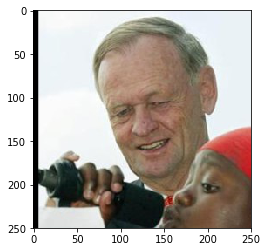

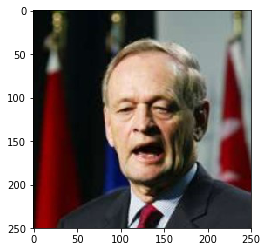

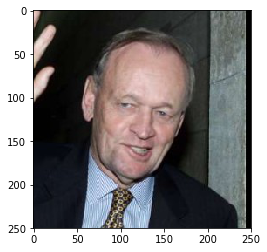

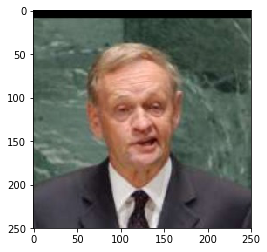

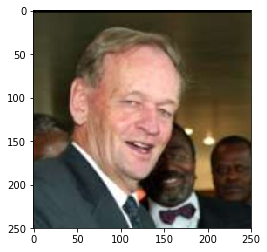

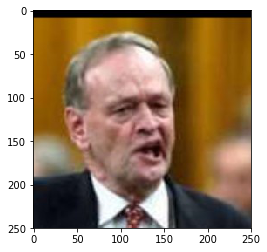

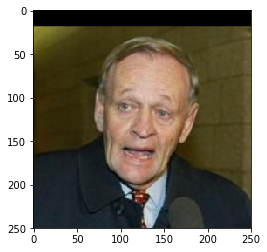

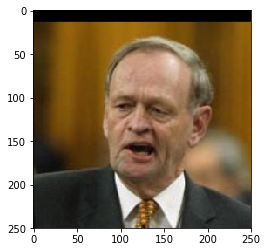

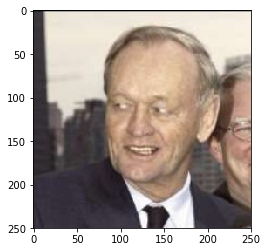

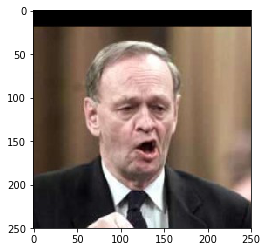

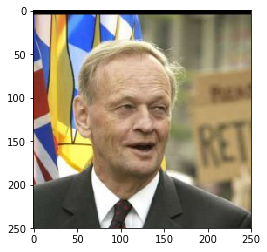

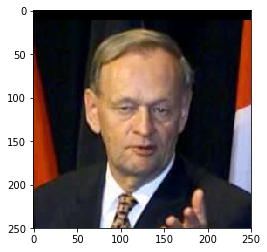

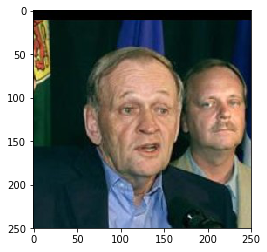

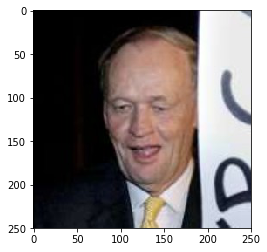

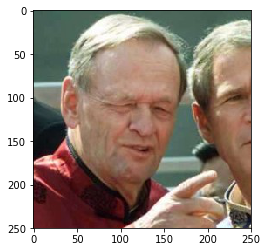

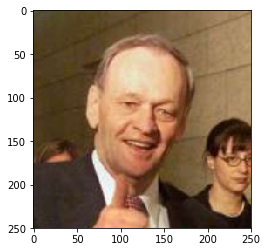

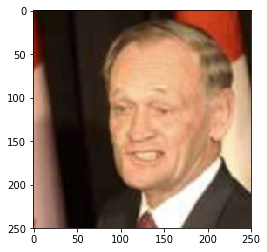

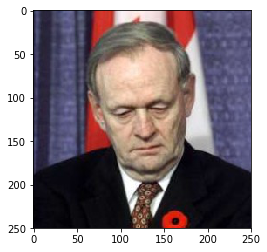

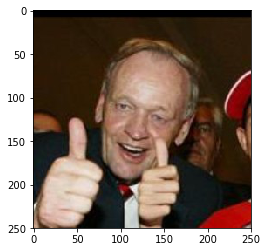

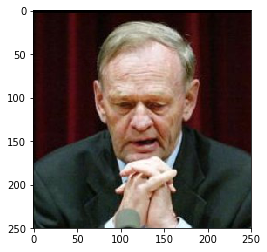

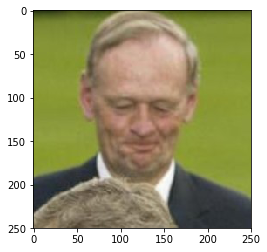

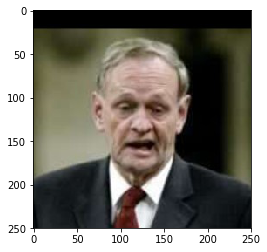

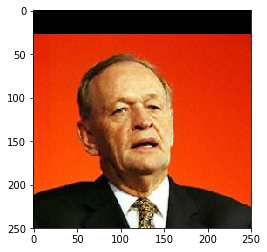

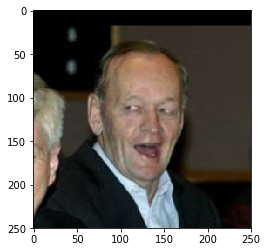

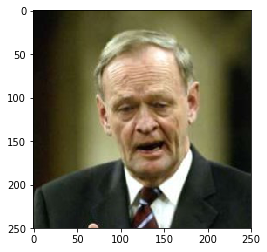

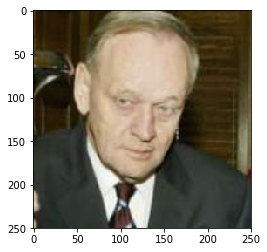

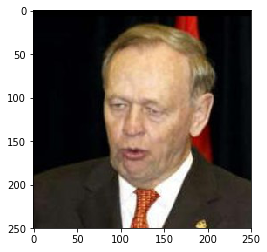

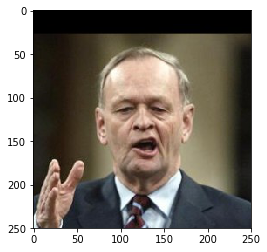

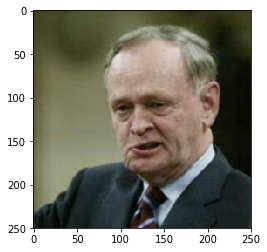

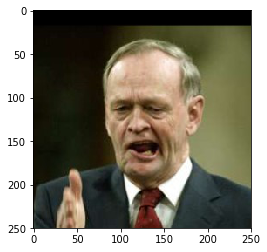

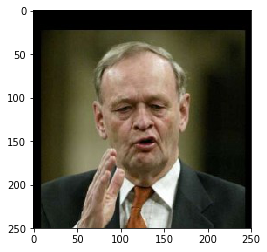

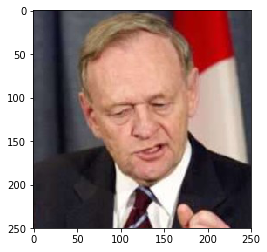

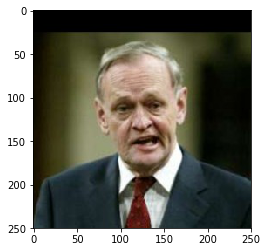

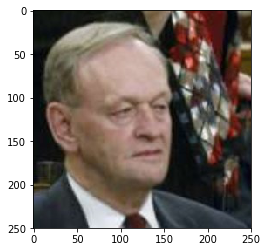

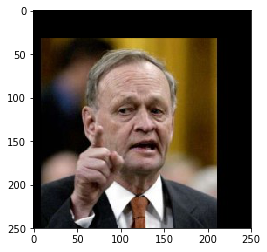

OSError: cannot identify image file 'data/Jean_Chretien/Thumbs.db'

In [10]:
#Afficher des images utilisées
Mesimages=os.listdir('data/Jean_Chretien/') 
for i in Mesimages: 
    image = Image.open('data/Jean_Chretien/'+i)
    plot_image(image)

In [11]:
#Application de PCP à mes images: 
L, S, (u, s, v),rang_L,norme_S,pcp_time = pcp(M, maxiter=10000)


Iteration 0: error=8.630e-03, rank(L)=35, Norme(S)=560478, time=2.153e+00
Iteration 1: error=1.594e-04, rank(L)=35, Norme(S)=580808, time=1.314e+00
Iteration 2: error=8.658e-05, rank(L)=35, Norme(S)=591816, time=1.386e+00
Iteration 3: error=8.450e-05, rank(L)=35, Norme(S)=602374, time=1.353e+00
Iteration 4: error=8.511e-05, rank(L)=35, Norme(S)=613250, time=1.151e+00
Iteration 5: error=8.581e-05, rank(L)=35, Norme(S)=624086, time=1.985e+00
Iteration 6: error=8.651e-05, rank(L)=35, Norme(S)=634965, time=1.350e+00
Iteration 7: error=8.720e-05, rank(L)=35, Norme(S)=645793, time=1.424e+00
Iteration 8: error=8.790e-05, rank(L)=35, Norme(S)=656999, time=1.025e+00
Iteration 9: error=8.857e-05, rank(L)=35, Norme(S)=668193, time=1.056e+00
Iteration 10: error=8.922e-05, rank(L)=35, Norme(S)=679615, time=1.721e+00
Iteration 11: error=8.990e-05, rank(L)=35, Norme(S)=691071, time=1.185e+00
Iteration 12: error=9.060e-05, rank(L)=35, Norme(S)=702347, time=1.019e+00
Iteration 13: error=9.124e-05, rank

Iteration 109: error=8.668e-05, rank(L)=28, Norme(S)=1612052, time=9.611e-01
Iteration 110: error=8.561e-05, rank(L)=28, Norme(S)=1615785, time=9.531e-01
Iteration 111: error=8.513e-05, rank(L)=28, Norme(S)=1619415, time=9.861e-01
Iteration 112: error=8.559e-05, rank(L)=27, Norme(S)=1622797, time=9.681e-01
Iteration 113: error=9.793e-05, rank(L)=27, Norme(S)=1625793, time=9.551e-01
Iteration 114: error=9.864e-05, rank(L)=27, Norme(S)=1628766, time=9.671e-01
Iteration 115: error=9.497e-05, rank(L)=27, Norme(S)=1631794, time=9.681e-01
Iteration 116: error=9.190e-05, rank(L)=27, Norme(S)=1634612, time=1.146e+00
Iteration 117: error=9.512e-05, rank(L)=26, Norme(S)=1637095, time=9.481e-01
Iteration 118: error=9.675e-05, rank(L)=25, Norme(S)=1639368, time=9.621e-01
Iteration 119: error=9.591e-05, rank(L)=25, Norme(S)=1641383, time=9.581e-01
Iteration 120: error=9.099e-05, rank(L)=25, Norme(S)=1643376, time=1.006e+00
Iteration 121: error=8.488e-05, rank(L)=25, Norme(S)=1645347, time=9.691e-01

Iteration 216: error=2.543e-05, rank(L)=20, Norme(S)=1739470, time=9.321e-01
Iteration 217: error=2.471e-05, rank(L)=20, Norme(S)=1739842, time=9.371e-01
Iteration 218: error=2.411e-05, rank(L)=20, Norme(S)=1740209, time=9.251e-01
Iteration 219: error=2.354e-05, rank(L)=20, Norme(S)=1740596, time=9.291e-01
Iteration 220: error=2.298e-05, rank(L)=20, Norme(S)=1740993, time=9.211e-01
Iteration 221: error=2.250e-05, rank(L)=20, Norme(S)=1741379, time=9.381e-01
Iteration 222: error=2.219e-05, rank(L)=20, Norme(S)=1741702, time=9.261e-01
Iteration 223: error=2.185e-05, rank(L)=20, Norme(S)=1741992, time=9.241e-01
Iteration 224: error=2.153e-05, rank(L)=20, Norme(S)=1742317, time=9.251e-01
Iteration 225: error=2.128e-05, rank(L)=20, Norme(S)=1742619, time=9.291e-01
Iteration 226: error=2.102e-05, rank(L)=20, Norme(S)=1742910, time=9.361e-01
Iteration 227: error=2.078e-05, rank(L)=20, Norme(S)=1743262, time=9.441e-01
Iteration 228: error=2.053e-05, rank(L)=20, Norme(S)=1743573, time=9.371e-01

Iteration 323: error=8.396e-06, rank(L)=19, Norme(S)=1760148, time=9.201e-01
Iteration 324: error=8.311e-06, rank(L)=19, Norme(S)=1760243, time=9.351e-01
Iteration 325: error=8.242e-06, rank(L)=19, Norme(S)=1760356, time=9.241e-01
Iteration 326: error=8.179e-06, rank(L)=19, Norme(S)=1760451, time=9.491e-01
Iteration 327: error=8.134e-06, rank(L)=19, Norme(S)=1760534, time=9.301e-01
Iteration 328: error=8.079e-06, rank(L)=19, Norme(S)=1760575, time=9.341e-01
Iteration 329: error=8.008e-06, rank(L)=19, Norme(S)=1760677, time=9.241e-01
Iteration 330: error=7.941e-06, rank(L)=19, Norme(S)=1760734, time=9.451e-01
Iteration 331: error=7.890e-06, rank(L)=19, Norme(S)=1760795, time=9.221e-01
Iteration 332: error=7.822e-06, rank(L)=19, Norme(S)=1760852, time=9.871e-01
Iteration 333: error=7.737e-06, rank(L)=19, Norme(S)=1760931, time=9.761e-01
Iteration 334: error=7.644e-06, rank(L)=19, Norme(S)=1760991, time=1.399e+00
Iteration 335: error=7.579e-06, rank(L)=19, Norme(S)=1761048, time=9.851e-01

Iteration 430: error=3.562e-06, rank(L)=19, Norme(S)=1765438, time=9.681e-01
Iteration 431: error=3.533e-06, rank(L)=19, Norme(S)=1765448, time=9.671e-01
Iteration 432: error=3.523e-06, rank(L)=19, Norme(S)=1765457, time=1.110e+00
Iteration 433: error=3.506e-06, rank(L)=19, Norme(S)=1765491, time=1.088e+00
Iteration 434: error=3.481e-06, rank(L)=19, Norme(S)=1765505, time=9.691e-01
Iteration 435: error=3.508e-06, rank(L)=18, Norme(S)=1765528, time=1.491e+00
Iteration 436: error=3.659e-06, rank(L)=18, Norme(S)=1765535, time=1.099e+00
Iteration 437: error=3.686e-06, rank(L)=18, Norme(S)=1765560, time=1.627e+00
Iteration 438: error=3.637e-06, rank(L)=18, Norme(S)=1765581, time=1.020e+00
Iteration 439: error=3.552e-06, rank(L)=18, Norme(S)=1765604, time=1.341e+00
Iteration 440: error=3.464e-06, rank(L)=18, Norme(S)=1765608, time=1.333e+00
Iteration 441: error=3.406e-06, rank(L)=18, Norme(S)=1765626, time=1.583e+00
Iteration 442: error=3.351e-06, rank(L)=18, Norme(S)=1765652, time=1.313e+00

Iteration 537: error=1.612e-06, rank(L)=18, Norme(S)=1766577, time=9.831e-01
Iteration 538: error=1.596e-06, rank(L)=18, Norme(S)=1766597, time=1.040e+00
Iteration 539: error=1.582e-06, rank(L)=18, Norme(S)=1766605, time=1.146e+00
Iteration 540: error=1.568e-06, rank(L)=18, Norme(S)=1766611, time=1.167e+00
Iteration 541: error=1.555e-06, rank(L)=18, Norme(S)=1766614, time=1.097e+00
Iteration 542: error=1.545e-06, rank(L)=18, Norme(S)=1766616, time=1.582e+00
Iteration 543: error=1.541e-06, rank(L)=18, Norme(S)=1766611, time=1.264e+00
Iteration 544: error=1.530e-06, rank(L)=18, Norme(S)=1766628, time=1.147e+00
Iteration 545: error=1.515e-06, rank(L)=18, Norme(S)=1766625, time=1.191e+00
Iteration 546: error=1.505e-06, rank(L)=18, Norme(S)=1766631, time=1.322e+00
Iteration 547: error=1.493e-06, rank(L)=18, Norme(S)=1766638, time=1.042e+00
Iteration 548: error=1.476e-06, rank(L)=18, Norme(S)=1766644, time=1.247e+00
Iteration 549: error=1.461e-06, rank(L)=18, Norme(S)=1766651, time=1.063e+00

In [16]:
print(pcp_time)

1770.1054918766022


L'algorithme a besoin de 601 itérations, faites en 1770 secondes pour converger.

In [12]:
#Fonction pour afficher les images obtenues à la suite de PCP
def do_plot(ax, img, shape):
    ax.cla()
    ax.imshow(img.reshape(shape), cmap="gray", interpolation="nearest")
    ax.figure
    ax.set_xticklabels([])
    ax.set_yticklabels([])


In [13]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
fig.subplots_adjust(left=0, right=1, hspace=0, wspace=0.01)
for i in range(min(len(M), 500)):
    do_plot(axes[0], M[i], shape)
    axes[0].set_title("Image originale")
    do_plot(axes[1], L[i], shape)
    axes[1].set_title("low rank")
    do_plot(axes[2], S[i], shape)
    axes[2].set_title("sparse error")
    fig.savefig("results/Jean_Chretien/{0:05d}.png".format(i))

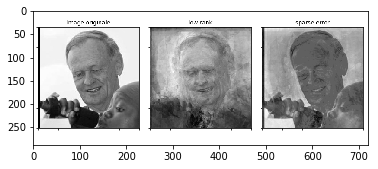

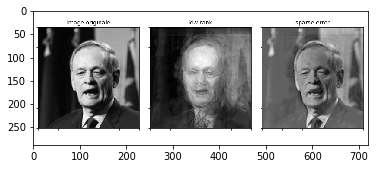

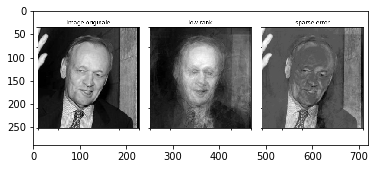

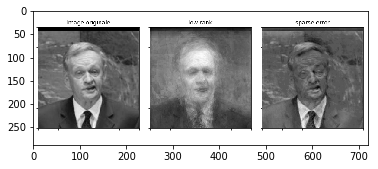

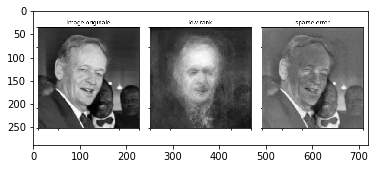

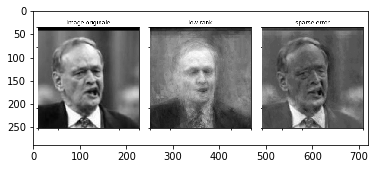

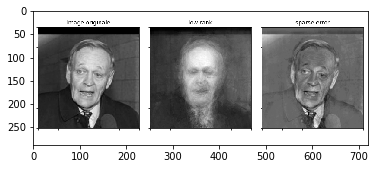

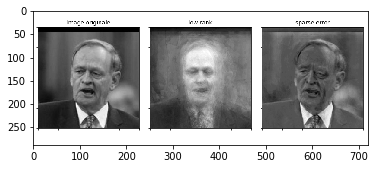

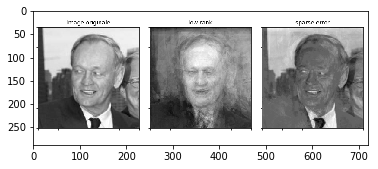

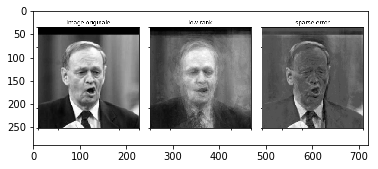

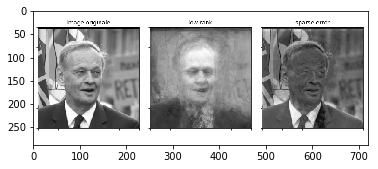

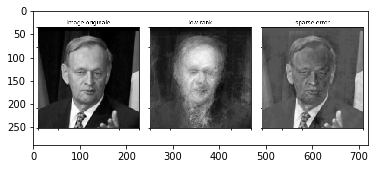

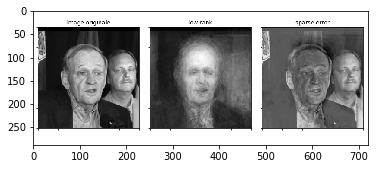

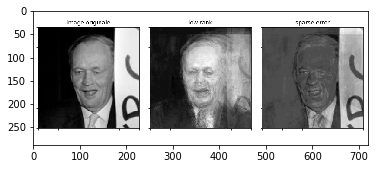

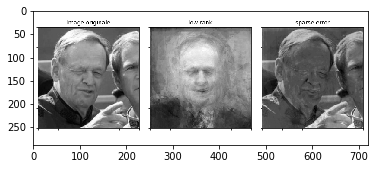

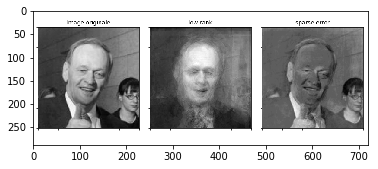

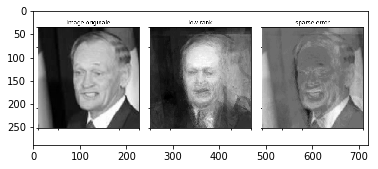

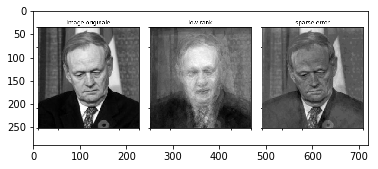

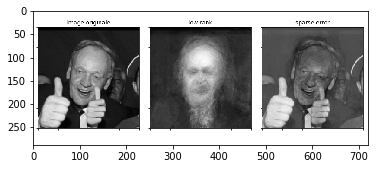

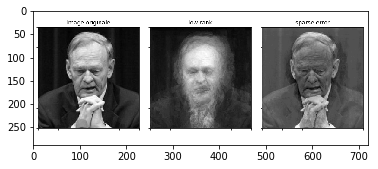

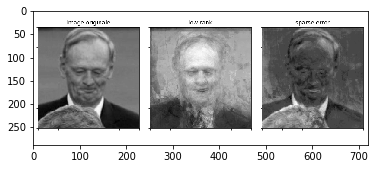

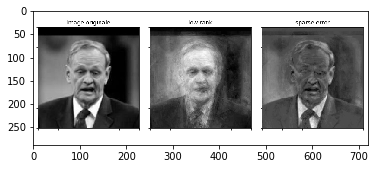

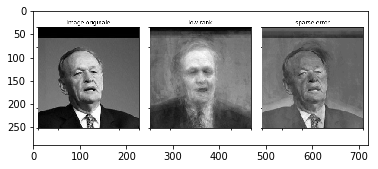

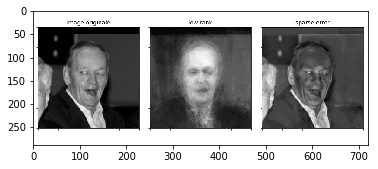

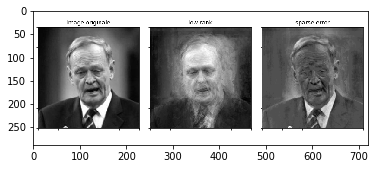

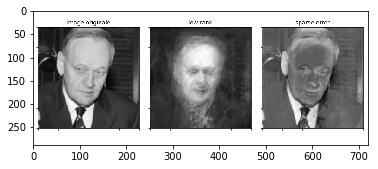

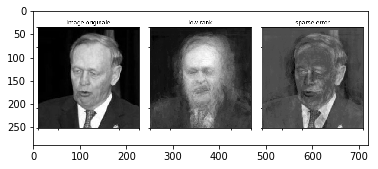

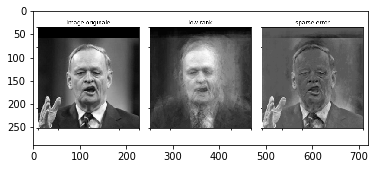

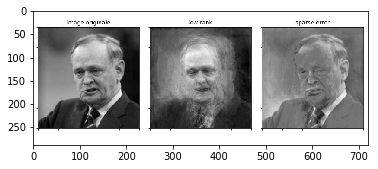

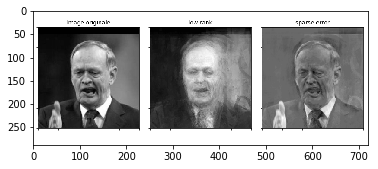

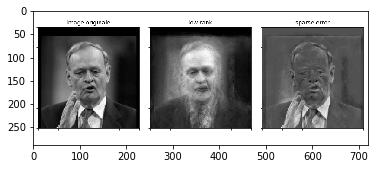

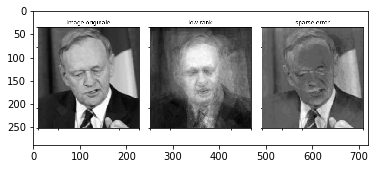

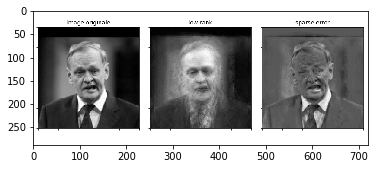

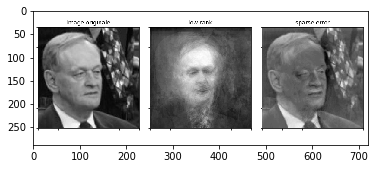

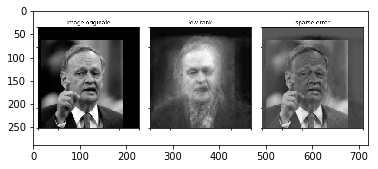

In [15]:
Mesimages=os.listdir('results/Jean_Chretien/') 
for i in Mesimages: 
    image = Image.open("results/Jean_Chretien/"+i)
    plot_image(image)

Des perturbations comme la présence de mains sur la photo, une expression différente du visage, ou encore un motif de cravate, sont capturées par la composante sparse. La composante de faible rang, elle, renvoie un visage avec une expression neutre. 

On peut voir que les images prises de face et bien droites sont beaucoup mieux traitées que celles qui sont moins bien cadrées.